# Inits

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.linear_model import LinearRegression
import joblib

# Organizing, scaling data for ML methods
All columns not relating to predicting score (INCLUDING non-normalized distance from TSS) are dropped in the creation of the training and test sets

In [2]:
df = pd.read_csv("structured_set.csv")

X = df.drop(columns = ["score", 
                       "gene", 
                       "chromosome",
                       "PAM_coord",
                       "strand targeted", 
                       "sequence", 
                       "transcript", 
                       "strand", 
                       "TSS source",
                       "prim_TSS_5p",
                       "prim_TSS_3p",
                       "sec_TSS_5p",
                       "sec_TSS_3p",
                       "prim_TSS_dist5p",
                       "prim_TSS_dist3p",
                       "sec_TSS_dist5p",
                       "sec_TSS_dist3p"])
y = df.loc[:, "score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Random Forest Regression
Gilbert and his lab used elastic net linear regression - I tried this, but it just wasn't working. Random forest offers a more robust analysis and cares less about the scale of the features, but is more black box and harder to interpret.

## Fitting model

In [9]:
from sklearn.ensemble import RandomForestRegressor

# rf_reg = RandomForestRegressor()

# params = {
#     "n_estimators": Integer(1, 500),
#     "max_depth": Integer(1, 100),
#     "min_samples_leaf": Real(0.0001, 0.1, prior = "log-uniform")
# }

# grid_rf_reg = BayesSearchCV(rf_reg, params, scoring = "neg_mean_squared_error", n_iter = 50, n_jobs = -1, cv = 5, n_points = 5, verbose = 1)
# _ = grid_rf_reg.fit(X_train, y_train)
# joblib.dump(best_rf_reg, "models/RF.joblib", compress = c("lzma", 3))

best_rf_reg = joblib.load("models/RF.joblib")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


## Comparing model fit with test set

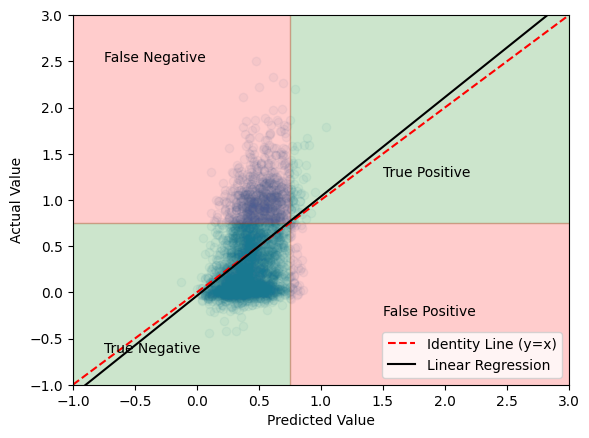

In [10]:
pred_score = best_rf_reg.predict(X)
y_pred = best_rf_reg.predict(X_test)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0

x = np.linspace(xmin, xmax, 100)
xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.05)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.plot(x, lin_reg.predict(x.reshape(-1, 1)), color = "black", label = "Linear Regression") # plotting linear regression
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

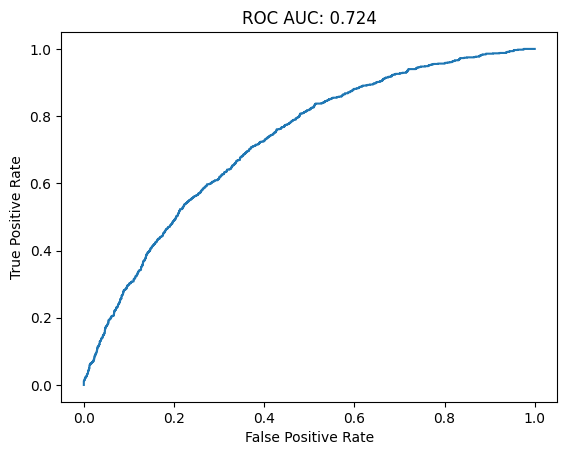

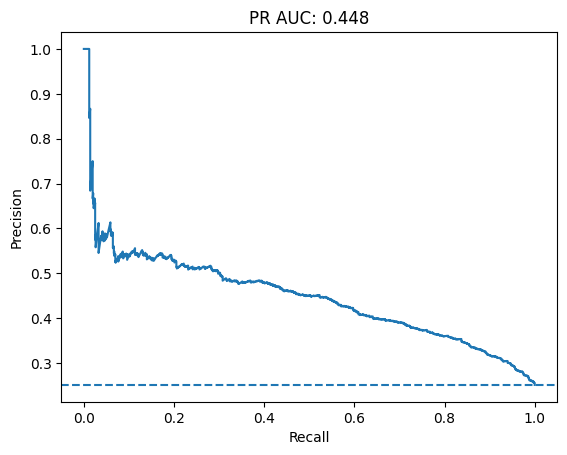

F1 score:  0.11568627450980393


In [11]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold
prevalence = np.sum(y_prob) / len(y_prob)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)

## Feature importances

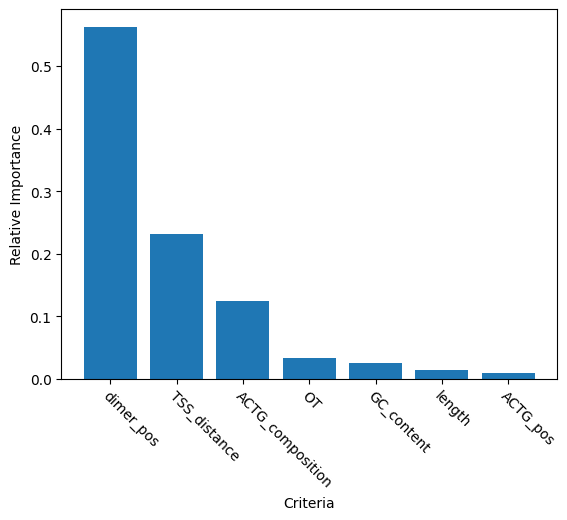

In [72]:
imp_title = ["length"] + (["TSS_distance"] * 4) + (["ACTG_composition"] * 4) + ["GC_content"] + (["ACTG_pos"] * (4 * 25)) + (["dimer_pos"] * ((4 ** 2) * 25)) + (["OT"] * 3)
imp_df = pd.concat([pd.DataFrame({"importance": best_rf_reg.feature_importances_}), 
                    pd.DataFrame({"title": imp_title})], axis = 1)
grouped_imp_df = imp_df.groupby("title").sum().reset_index().sort_values(by = "importance", ascending = False)

plt.figure()
plt.bar(grouped_imp_df["title"], grouped_imp_df["importance"])
plt.xticks(rotation = -45, ha = "left", rotation_mode = "anchor")
plt.xlabel("Criteria")
plt.ylabel("Relative Importance")
plt.show()

# Gradient Boosting Regression
Allegedly more robust than random forest regression.

## Fitting model

In [139]:
from lightgbm import LGBMRegressor, early_stopping

# lgbm_reg = LGBMRegressor(verbose = 0)

# params = {
#     "n_estimators": Integer(50, 500),
#     "learning_rate": Real(0.01, 0.3),
#     "num_leaves": Integer(2, 100),
#     "reg_lambda": Real(0, 1),
#     "reg_alpha": Real(0, 1),
# }

# grid_lgbm_reg = BayesSearchCV(lgbm_reg, params, scoring = "r2", n_iter = 30, cv = 5, n_points = 2, verbose = 1)
# _ = grid_lgbm_reg.fit(X_train, y_train)
# with open("models/LGBM.pk1", "wb") as file:
#     pickle.dump(grid_lgbm_reg.best_estimator_, file)
    
with open("models/LGBM.pk1", "rb") as file:
    best_lgbm_reg = pickle.load(file)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

## Comparing model fit with test set

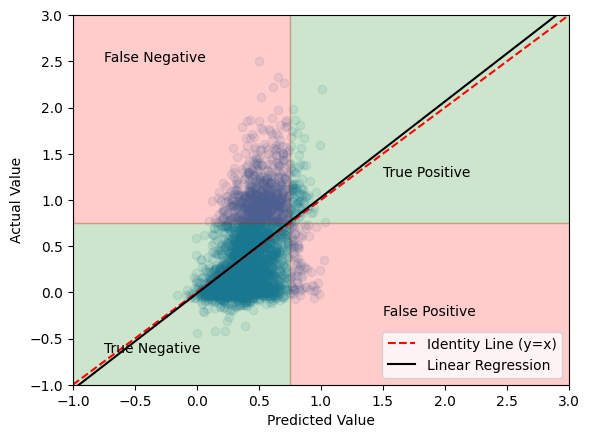

In [149]:
pred_score = best_lgbm_reg.predict(X)
y_pred = best_lgbm_reg.predict(X_test)

threshold = 0.75 # threshold by where we consider an sgRNA to be "highly active"
xmin = -1 # minimum on x axis
xmax = 3 # maximum on x axis

# fitting a linear regression to the data
lin_reg = LinearRegression()
lin_reg.fit(y_pred.reshape(-1, 1), y_test)
slope = lin_reg.coef_[0] # perfect fit, slope = 1
intercept = lin_reg.intercept_ # perfect fit, intercept = 0

x = np.linspace(xmin, xmax, 100)
xdist = (threshold - xmin) / (xmax - xmin) # distance along the x axis to place the location of threshold
plt.scatter(y_pred, y_test, alpha = 0.1)
plt.plot(x, x, color = 'red', linestyle = '--', label = 'Identity Line (y=x)')
plt.plot(x, lin_reg.predict(x.reshape(-1, 1)), color = "black", label = "Linear Regression") # plotting linear regression
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.axhspan(-5, threshold, color = "green", alpha = 0.2, xmax = xdist) # true negative
plt.axhspan(threshold, 5, color = "green", alpha = 0.2, xmin = xdist) # true positive
plt.axhspan(-5, threshold, color = "red", alpha = 0.2, xmin = xdist) # false positive
plt.axhspan(threshold, 5, color = "red", alpha = 0.2, xmax = xdist) # false negative
plt.text(1.5, 1.25, "True Positive")
plt.text(-0.75, -0.65, "True Negative")
plt.text(1.5, -0.25, "False Positive")
plt.text(-0.75, 2.5, "False Negative")
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.legend()
plt.show()

## ROC curve (and other metrics)

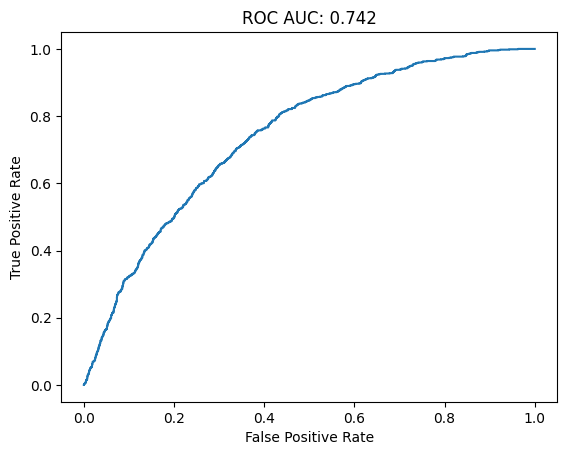

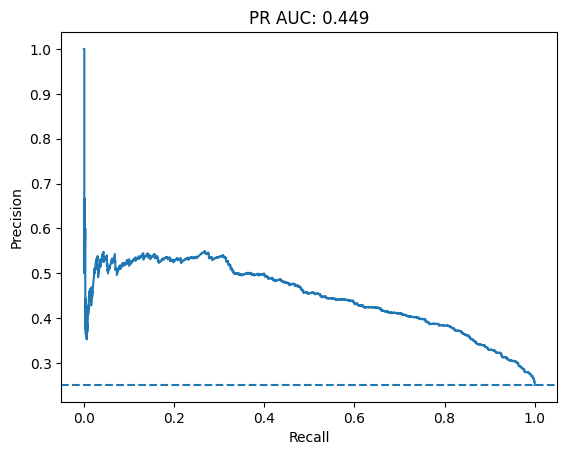

F1 score:  0.1684981684981685


In [141]:
actual_pos = df["score"] >= threshold
y_prob = y_test >= threshold

# ROC curve
fpr, tpr, thresholds = roc_curve(y_prob, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title("ROC AUC: " + str(round(roc_auc, 3)))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# precision-recall curve
precision, recall, threshholds = precision_recall_curve(y_prob, y_pred)
roc_pr = auc(recall, precision)

plt.figure()
plt.title("PR AUC: " + str(round(roc_pr, 3)))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(prevalence, linestyle = "--")
plt.show()

# f1 score
f1 = f1_score(y_prob, y_pred >= threshold)
print("F1 score: ", f1)